In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from rich import print as rprint
from torch import nn

from analysis.common import load_model
from analysis.residual_alignment_methods import alignment, plotsvals, sab, trajectories
from koopmann import aesthetics
from koopmann.data import (
    DatasetConfig,
    create_data_loader,
    get_dataset_class,
)
from koopmann.models import MLP, ResMLP
from koopmann.models.utils import parse_safetensors_metadata
from koopmann.utils import (
    compute_model_accuracy,
)
from koopmann.visualization import plot_decision_boundary

%load_ext autoreload
%autoreload 2

In [2]:
file_dir = "/scratch/nsa325/koopmann_model_saves/"
model_name = "cifar10_resnet"

In [3]:
model, model_metadata = load_model(file_dir, model_name)
model.hook_model()
print(model_metadata)

{'batchnorm': 'True', 'bias': 'True', 'blocks_per_stage': '[16]', 'channels_config': '[64]', 'dataset': 'CIFAR10Dataset', 'in_channels': '3', 'initial_downsample_factor': '2', 'input_size': '(32, 32)', 'nonlinearity': 'relu', 'out_channels': '10', 'stochastic_depth_mode': 'batch', 'stochastic_depth_prob': '0.0'}


In [4]:
# Dataset config
dataset_config = DatasetConfig(
    dataset_name=model_metadata["dataset"],
    num_samples=3_000,
    split="test",
    seed=42,
)
DatasetClass = get_dataset_class(name=dataset_config.dataset_name)
dataset = DatasetClass(config=dataset_config)
dataloader = create_data_loader(dataset, batch_size=256)

Files already downloaded and verified


In [5]:
rprint(f"Testing Accuracy: {compute_model_accuracy(model, dataset)}")

Testing Accuracy: 0.8673999905586243

In [6]:
if dataset.in_features == 2:
    plot_decision_boundary(
        model,
        model.state_dict(),
        dataset.features,
        dataset.labels.squeeze(),
        labels=[0, 1, 2],
    )

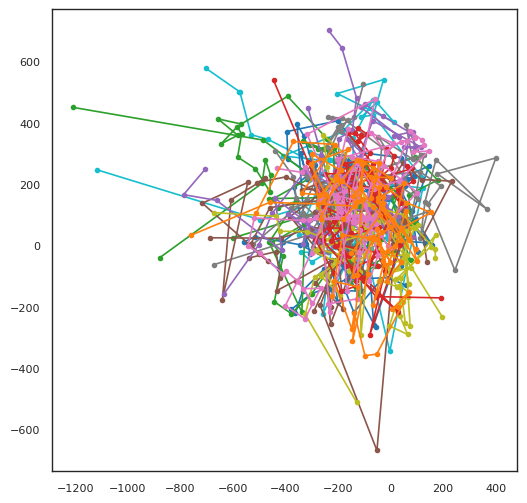

In [8]:
model.eval()
if "resnet" in model_name or "residual" in model_name:
    sab(model)
    trajectories(model, dataloader, 10, 5)
    images, labels = next(iter(dataloader))
    x = images[0]
    _ = model(x.unsqueeze(0))
    acts, patts = model.get_fwd_acts_patts()
    acts = list(acts.values())
    patts = list(patts.values())
    # JUSV = plotsvals(acts, patts, title="Test")
    # alignment(acts, patts, title="Test", JUSV=JUSV)